# ETAS_SingleCatalog trimmed
Train NTPP and ETAS models on different training set sizes on White et al. catalog (Mc = 0.6)

In [1]:
import torch
import eq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seml
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
catalog = eq.catalogs.ETAS_SingleCatalog()

Loading existing catalog from /nfs/homedirs/shchur/research/earthquake-ntpp-release/data/ETAS_SingleCatalog.


## Load NTPP results from the database

In [3]:
df = seml.get_results("eq_trimmed", to_data_frame=True)
df.sort_values(by="config.train_fraction", inplace=True)
df = df.query("`config.dataset_name` == 'ETAS_SingleCatalog'")
df.fillna(0.0, inplace=True)

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

In [4]:
df["num_events_train"] = df["result.num_events_train"] + df["result.num_events_val"]

In [5]:
results_ntpp = df[["config.model_name", "config.random_seed", "num_events_train", "result.final_nll_test"]]
results_ntpp.columns = ["model_name", "random_seed", "num_events_train", "nll_test"]

## Compute ETAS NLL

In [6]:
etas = eq.models.ETAS(
    omori_p_init=catalog.metadata["omori_p"],
    omori_c_init=catalog.metadata["omori_c"],
    base_rate_init=catalog.metadata["base_rate"],
    productivity_alpha_init=catalog.metadata["productivity_alpha"],
    productivity_k_init=catalog.metadata["productivity_k"],
    richter_b=catalog.metadata["richter_b"],
).double()

In [7]:
with torch.no_grad():
    nll_etas = etas.nll_loss(eq.data.Batch.from_list([catalog.test[0].double()])).item()

In [8]:
results_etas = []
for n_train in results_ntpp.num_events_train.unique():
    results_etas.append({
        "model_name": "ETAS",
        "random_seed": 0.0,
        "num_events_train": n_train,
        "nll_test": nll_etas,
    })
results_etas = pd.DataFrame(results_etas)

## Combine results

In [9]:
results = pd.concat([results_ntpp, results_etas])

In [10]:
results["loglike_test"] = -results["nll_test"]
results.reset_index(drop=True, inplace=True)

In [11]:
results.to_csv("../../results/ETAS_SingleCatalog_trimmed.csv")

## Visualize the results

In [12]:
results = pd.read_csv("../../results/ETAS_SingleCatalog_trimmed.csv", index_col=0)

<AxesSubplot:xlabel='num_events_train', ylabel='loglike_test'>

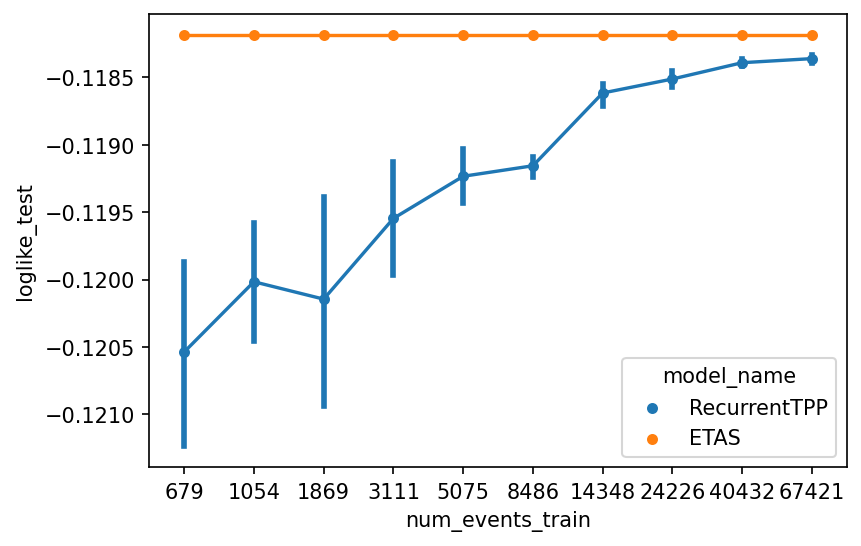

In [13]:
plt.figure(dpi=150)
sns.pointplot(data=results, x="num_events_train", y="loglike_test", hue="model_name", scale=0.6)